# Pobieranie i importy

In [ ]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#manipulacja danymi
import pandas as pd
import numpy as np
import math

#wizualizacja
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#scraping
import snscrape.modules.twitter as sntwitter
import requests
import re

#czasowe
from time import sleep
from datetime import date
import datetime

#przygotowanie danych
from sklearn.preprocessing import MinMaxScaler

# Definiowanie Pozyskiwania danych

##Wiadomości z Tweetera i portali

###Twitter

In [ ]:
def get_tweets_by_query(query, no_tweets):
  tweets = []
  for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if len(tweets) == no_tweets:
      break
    else:
      tweets.append([tweet.date, tweet.username, tweet.content])

  print(f'Pobrano Tweety zawierające: {query}')
  return tweets


def get_tweets_by_queries(no_tweets):
  queries = ['giełda', 'GPW', 'WIG', 'WIG20', 'WIG30', 'sWIG80', 'mWIG40', 'NewConect', 'spółka', 'cena', 'kredyt', 'firma', 
              'gospodarka', 'rynek', 'akcje', 'waluta', 'surowce', 'nieruchomości', 'fabryka', 'bezrobocie', 
             'wskaźnik', 'przemysł', 'zamówienia', 'przedsiębiorstwa', 'produkcja' ] #lista zapytań do pobrania
  tweets = []
  for query in queries:
    tweets.extend(get_tweets_by_query(query, no_tweets))

  df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
  return df


#-------------------------------------------------------------



def get_tweets_by_user(user_name, no_tweets):
  tweets = []
  user = f'(from:{user_name})'
  for tweet in sntwitter.TwitterSearchScraper(user).get_items():
    if len(tweets) == no_tweets:
      break
    else:
      tweets.append([tweet.date, tweet.username, tweet.content])

  print(f'Pobrano Tweety Użytkownika: {user_name}')
  return tweets


def get_tweets_by_users(no_tweets):
  users = ['StockWatchPL','pl_krn','MikRaczynski', 'mbank_research', 'PrzemekSNR', 'pbujak', 'strefainw', 'DPackowski',
           'TrysteroBlog', 'analizy_pl', 'Wilk_z_GPW', 'biznesradar', 'comparic', 'JakInwestowac','RPEkonomia', 'BIPolska',
           'OFinansowy', 'puls_biznesu', 'GPW_WSExchange', 'BiznesAlert', 'PKO_Research', 'GUS_STAT'] #lista użytkowników do pobrania
  tweets = []
  for user in users:
    tweets.extend(get_tweets_by_user(user, no_tweets))

  df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
  return df


#-------------------------------------------------------------



def get_twitter_data(no_tweets):
  
  users = get_tweets_by_users(no_tweets)
  #queries = get_tweets_by_queries(no_tweets)
  #tweeter_data = pd.concat([users, queries], ignore_index=True)
  #tweeter_data['Date'] = tweeter_data['Date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
  users['Date'] = users['Date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
  
  return users
  #return tweeter_data

###Biznes Radar

In [ ]:
def get_biznesradar(number_of_pages):
    
    all_dates = []
    all_titles = []
    all_content = []
    
    for page_number in range(1, number_of_pages+1):
        print(f'Pobieram informacje gospodarcze z Biznes Radar - strona numer {page_number}')
        
        http_address = f'https://www.biznesradar.pl/news-archive/1,{page_number}'
        response = requests.get(http_address)
        content = response.content.decode("utf-8")

        dates = re.findall(r'"record-date">(.+?)\s\d\d.\d\d.\d\d</span>', content, re.DOTALL)
        all_dates.extend(dates)
        

        titles = re.findall(r'<a target="_blank" href.+?rel="nofollow">(.+?)</a>', content, re.DOTALL)
        all_titles.extend(titles)
        
        content = re.findall(r'<div class="record-body">\n\t\t\t\s+(.+?)\n\t\t', content, re.DOTALL)
        all_content.extend(content)
        
        sleep(1)
    
    total = {'Date':all_dates, 'Title': all_titles, 'Content': all_content}
    total =  pd.DataFrame(total)
    #total['Date'] = total['Date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
    return total

###bankier.pl

In [ ]:
def get_bankierpl_gospodarka(number_of_pages):
    
    all_dates = []
    all_titles = []
    all_content = []
    
    for page_number in range(1, number_of_pages+1):
        print(f'Pobieram informacje gospodarcze z bankier.pl - strona numer {page_number}')
        
        http_address = f'https://www.bankier.pl/gospodarka/wiadomosci/{page_number}' #max100
        response = requests.get(http_address)
        content = response.content.decode("utf-8")

        data = re.findall(r'<time class="entry-date".+?pubdate>(.+?)\s\d\d.\d\d</time>\n', content, re.DOTALL)
        y = 0
        for x in data:
          if y==10:
            break
          else:
            all_dates.append(x)
            y+=1

        titles = re.findall(r'rel="bookmark">\n\s+(.+?)\n\n', content, re.DOTALL)
        all_titles.extend(titles)
        
        content = re.findall(r'</span>\n\n\s+<p>(.+?)<a href', content, re.DOTALL)
        all_content.extend(content)
        
        sleep(1)
    
    total = {'Date':all_dates, 'Title': all_titles, 'Content': all_content}
    return pd.DataFrame(total)

#-------------------------------------------------------------------------------------

def get_bankierpl_rynki(number_of_pages):
    
    all_dates = []
    all_titles = []
    all_content = []
    
    for page_number in range(1, number_of_pages+1):
        print(f'Pobieram komentarze rynkowe z bankier.pl - strona numer {page_number}')
        
        http_address = f'https://www.bankier.pl/rynki/wiadomosci/{page_number}' #max 65
        response = requests.get(http_address)
        content = response.content.decode("utf-8")

        data = re.findall(r'<time class="entry-date".+?pubdate>(.+?)\s\d\d.\d\d</time>\n', content, re.DOTALL)
        y = 0
        for x in data:
          if y==15:
            break
          else:
            all_dates.append(x)
            y+=1

        titles = re.findall(r'rel="bookmark">\n\s+(.+?)\n\n', content, re.DOTALL)
        all_titles.extend(titles)
        
        content = re.findall(r'</span>\n\n\s+<p>(.+?)<a href', content, re.DOTALL)
        all_content.extend(content)
        
        sleep(1)
    
    total = {'Date':all_dates, 'Title': all_titles, 'Content': all_content}
    return pd.DataFrame(total)


def get_bankierpl(number_of_pages):

  gospodarka = get_bankierpl_gospodarka(number_of_pages)
  rynki = get_bankierpl_rynki(number_of_pages)
  dane = pd.concat([gospodarka, rynki], ignore_index=True)
  #dane['Date'] = dane['Date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
  dane = dane.sort_values(by='Date', ignore_index=True)
  return dane

###get_portals

In [ ]:
def get_portals(number_of_pages):
  biznesradar = get_biznesradar(number_of_pages)
  bankier = get_bankierpl(number_of_pages)
  dane = pd.concat([biznesradar, bankier], ignore_index=True)
  dane.sort_values(by="Date", ascending = False, ignore_index=True)
  return dane, biznesradar, bankier


##Spółki WIG20

In [ ]:
tiki = ['acp', 'ale', 'ccc', 'cdr', 'cps', 'dnp', 
        'jsw', 'kgh', 'kty', 'lpp', 'mbk', 'opl', 'pco', 
        'peo', 'pge', 'pgn', 'pkn', 'pko', 'pzu', 'spl']

tiki_zamkniecie = []
for tik in tiki:
  tiki_zamkniecie.append(f'{tik} Zamkniecie')

tiki_zmiana = []
for tik in tiki:
  tiki_zmiana.append(f'{tik} Zmiana')

tiki_wolumen = []
for tik in tiki:
  tiki_wolumen.append(f'{tik} Wolumen')


# Pojedyncza spółka wszystkie dane

def get_company(tick):
  
    print(f'Pobieram ceny: {tick}')
    path = f'https://stooq.pl/q/d/l/?s={tick}&i=d'
    dataset = pd.read_csv(path)
    dataset['Data'] = pd.to_datetime(dataset['Data'])
    dataset['Zmiana'] = dataset["Zamkniecie"].pct_change()
    dataset = dataset[['Data', 'Zamkniecie', 'Wolumen', 'Zmiana']]
    dataset.columns = ['Data', f'{tick} Zamkniecie', f'{tick} Wolumen', f'{tick} Zmiana']
    dataset = dataset.set_index('Data')
    dataset = dataset[-2500:] #ostatnie 2500 dni pracujących / ok 10 lat
    return dataset

# Wszystkie spółki wszystkie dane -----------------------------------------------------------------------

def get_stocks():
  acp = get_company('acp') 
  ale = get_company('ale') #12 październik 2020
  ccc = get_company('ccc')
  cdr = get_company('cdr')
  cps = get_company('cps')
  dnp = get_company('dnp') # 19 kwietnia 2017
  jsw = get_company('jsw') 
  kgh = get_company('kgh')
  kty = get_company('kty') #jeden dzień brak notowań
  lpp = get_company('lpp')
  mbk = get_company('mbk')
  opl = get_company('opl')
  pco = get_company('pco') # 26 maj 2021
  peo = get_company('peo')
  pge = get_company('pge')
  pgn = get_company('pgn')
  pkn = get_company('pkn')
  pko = get_company('pko')
  pzu = get_company('pzu')
  spl = get_company('spl') #jeden dzień brak notowań
  wig20 = get_company('wig20')
  wig = get_company('wig')
  all = pd.concat([acp, ale, ccc, cdr, cps, dnp, 
        jsw, kgh, kty, lpp, mbk, opl, pco, 
        peo, pge, pgn, pkn, pko, pzu, spl], axis=1)

  return all, wig20, wig

#tylko zmiana procentowa -----------------------------------------------------------------------

def get_change(tick):
  
    print(f'Pobieram dzienne zmiany procentowe: {tick}')
    path = f'https://stooq.pl/q/d/l/?s={tick}&i=d'
    dataset = pd.read_csv(path)
    dataset['Data'] = pd.to_datetime(dataset['Data'])
    dataset['Zmiana'] = dataset["Zamkniecie"].pct_change()
    dataset = dataset[['Data', 'Zmiana']]
    dataset.columns = ['Data', f'{tick}']
    dataset = dataset.set_index('Data')
    dataset = dataset[-2500:] #ostatnie 2500 dni pracujących / ok 10 lat
    return dataset

def get_price_change():
  acp = get_change('acp') 
  ale = get_change('ale') #12 październik 2020
  ccc = get_change('ccc')
  cdr = get_change('cdr')
  cps = get_change('cps')
  dnp = get_change('dnp') # 19 kwietnia 2017
  jsw = get_change('jsw') 
  kgh = get_change('kgh')
  kty = get_change('kty') #jeden dzień brak notowań
  lpp = get_change('lpp')
  mbk = get_change('mbk')
  opl = get_change('opl')
  pco = get_change('pco') # 26 maj 2021
  peo = get_change('peo')
  pge = get_change('pge')
  pgn = get_change('pgn')
  pkn = get_change('pkn')
  pko = get_change('pko')
  pzu = get_change('pzu')
  spl = get_change('spl') #jeden dzień brak notowań

  all = pd.concat([acp, ale, ccc, cdr, cps, dnp, 
        jsw, kgh, kty, lpp, mbk, opl, pco, 
        peo, pge, pgn, pkn, pko, pzu, spl], axis=1)
  
  return all


#tylko wolumeny ------------------------------------------------------------------------

def get_volumen(tick):
  
    print(f'Pobieram dzienne wolumeny obrotu: {tick}')
    path = f'https://stooq.pl/q/d/l/?s={tick}&i=d'
    dataset = pd.read_csv(path)
    dataset['Data'] = pd.to_datetime(dataset['Data'])
    dataset = dataset[['Data', 'Wolumen']]
    dataset.columns = ['Data', f'{tick}']
    dataset = dataset.set_index('Data')
    dataset = dataset[-2500:] #ostatnie 2500 dni pracujących / ok 10 lat
    return dataset

def get_all_volumen():
  acp = get_volumen('acp') 
  ale = get_volumen('ale') #12 październik 2020
  ccc = get_volumen('ccc')
  cdr = get_volumen('cdr')
  cps = get_volumen('cps')
  dnp = get_volumen('dnp') # 19 kwietnia 2017
  jsw = get_volumen('jsw') 
  kgh = get_volumen('kgh')
  kty = get_volumen('kty') #jeden dzień brak notowań
  lpp = get_volumen('lpp')
  mbk = get_volumen('mbk')
  opl = get_volumen('opl')
  pco = get_volumen('pco') # 26 maj 2021
  peo = get_volumen('peo')
  pge = get_volumen('pge')
  pgn = get_volumen('pgn')
  pkn = get_volumen('pkn')
  pko = get_volumen('pko')
  pzu = get_volumen('pzu')
  spl = get_volumen('spl') #jeden dzień brak notowań

  all = pd.concat([acp, ale, ccc, cdr, cps, dnp, 
        jsw, kgh, kty, lpp, mbk, opl, pco, 
        peo, pge, pgn, pkn, pko, pzu, spl], axis=1)
  
  return all


# Pobieranie danych

##portale

In [ ]:
portals, biznesradar, bankier = get_portals(65) #max stron na bankier rynki

Pobieram informacje gospodarcze z Biznes Radar - strona numer 1
Pobieram informacje gospodarcze z Biznes Radar - strona numer 2
Pobieram informacje gospodarcze z Biznes Radar - strona numer 3
Pobieram informacje gospodarcze z Biznes Radar - strona numer 4
Pobieram informacje gospodarcze z Biznes Radar - strona numer 5
Pobieram informacje gospodarcze z Biznes Radar - strona numer 6
Pobieram informacje gospodarcze z Biznes Radar - strona numer 7
Pobieram informacje gospodarcze z Biznes Radar - strona numer 8
Pobieram informacje gospodarcze z Biznes Radar - strona numer 9
Pobieram informacje gospodarcze z Biznes Radar - strona numer 10
Pobieram informacje gospodarcze z Biznes Radar - strona numer 11
Pobieram informacje gospodarcze z Biznes Radar - strona numer 12
Pobieram informacje gospodarcze z Biznes Radar - strona numer 13
Pobieram informacje gospodarcze z Biznes Radar - strona numer 14
Pobieram informacje gospodarcze z Biznes Radar - strona numer 15
Pobieram informacje gospodarcze z 

##Twitter

In [ ]:
twitter = get_twitter_data(200)

Pobrano Tweety Użytkownika: StockWatchPL
Pobrano Tweety Użytkownika: pl_krn
Pobrano Tweety Użytkownika: MikRaczynski
Pobrano Tweety Użytkownika: mbank_research
Pobrano Tweety Użytkownika: PrzemekSNR
Pobrano Tweety Użytkownika: pbujak
Pobrano Tweety Użytkownika: strefainw
Pobrano Tweety Użytkownika: DPackowski
Pobrano Tweety Użytkownika: TrysteroBlog
Pobrano Tweety Użytkownika: analizy_pl
Pobrano Tweety Użytkownika: Wilk_z_GPW
Pobrano Tweety Użytkownika: biznesradar
Pobrano Tweety Użytkownika: comparic
Pobrano Tweety Użytkownika: JakInwestowac
Pobrano Tweety Użytkownika: RPEkonomia
Pobrano Tweety Użytkownika: BIPolska
Pobrano Tweety Użytkownika: OFinansowy
Pobrano Tweety Użytkownika: puls_biznesu
Pobrano Tweety Użytkownika: GPW_WSExchange
Pobrano Tweety Użytkownika: BiznesAlert
Pobrano Tweety Użytkownika: PKO_Research
Pobrano Tweety Użytkownika: GUS_STAT


##Giełda

In [ ]:
stocks, wig20, wig = get_stocks()

Pobieram ceny: acp
Pobieram ceny: ale
Pobieram ceny: ccc
Pobieram ceny: cdr
Pobieram ceny: cps
Pobieram ceny: dnp
Pobieram ceny: jsw
Pobieram ceny: kgh
Pobieram ceny: kty
Pobieram ceny: lpp
Pobieram ceny: mbk
Pobieram ceny: opl
Pobieram ceny: pco
Pobieram ceny: peo
Pobieram ceny: pge
Pobieram ceny: pgn
Pobieram ceny: pkn
Pobieram ceny: pko
Pobieram ceny: pzu
Pobieram ceny: spl
Pobieram ceny: wig20
Pobieram ceny: wig


#Wizualizacje ilości

##Ilość

###Wszystkie dane - ilość

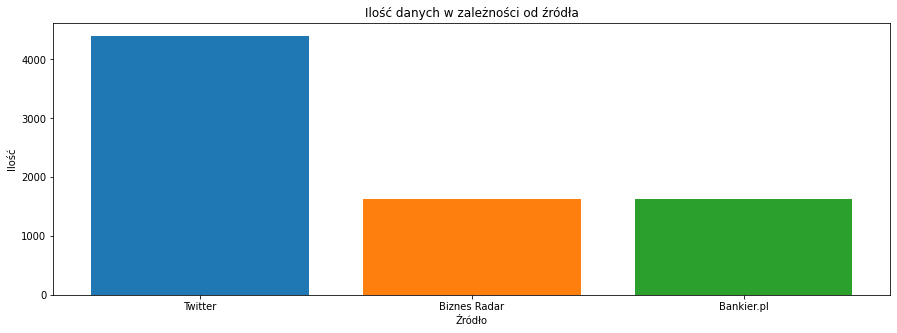

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
plt.bar("Twitter", len(twitter),)
plt.bar("Biznes Radar", len(biznesradar))
plt.bar("Bankier.pl", len(bankier))
ax.set_xlabel("Źródło")
ax.set_ylabel('Ilość')
plt.title('Ilość danych w zależności od źródła')
plt.show()

###Same portale - podział na ilość

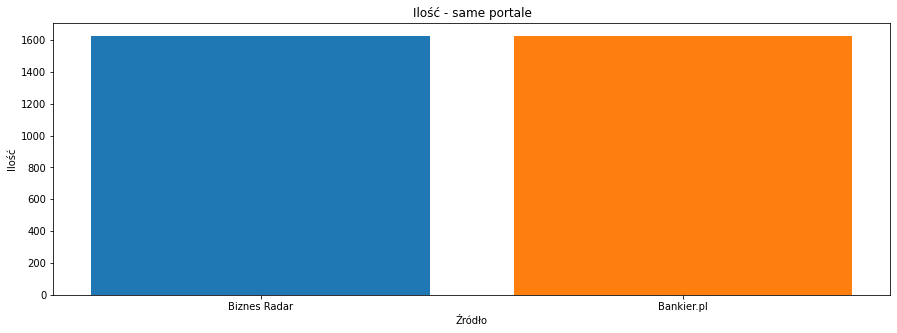

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
plt.bar("Biznes Radar", len(biznesradar))
plt.bar("Bankier.pl", len(bankier))
ax.set_xlabel("Źródło")
ax.set_ylabel('Ilość')
plt.title('Ilość - same portale')
plt.show()

## występowanie w czasie

###Twitter

In [ ]:
#tabela pokazująca ilość występowania w danych dniach
tw_uni_date = twitter['Date'].unique()
tw_dates = twitter['Date']
tw_uni_count = []
for x in tw_uni_date:
  num = 0
  for y in tw_dates:
    if x == y:
      num += 1
  tw_uni_count.append(num)
tweeter_by_date = {'Date':tw_uni_date, 'Count': tw_uni_count,}
tweeter_by_date = pd.DataFrame(tweeter_by_date)
tweeter_by_date['Date'] = tweeter_by_date['Date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
tweeter_by_date = tweeter_by_date.sort_values(by='Date', ignore_index=True)

Wszytskie tweety w czasie

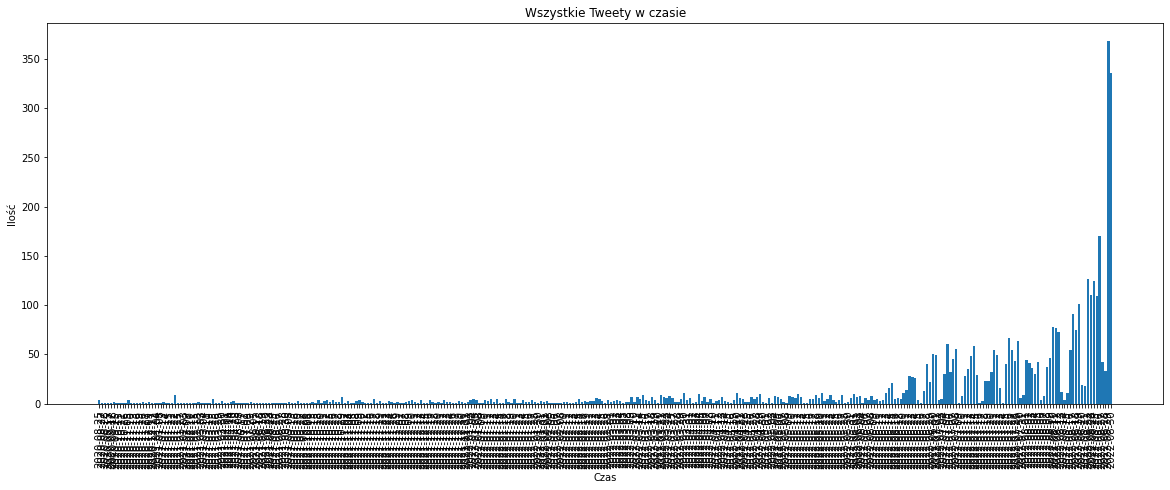

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
plt.bar(tweeter_by_date.Date, tweeter_by_date.Count)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("Czas")
ax.set_ylabel('Ilość')
plt.title("Wszystkie Tweety w czasie")
plt.show()

Tweety - ostatnie 30 dni

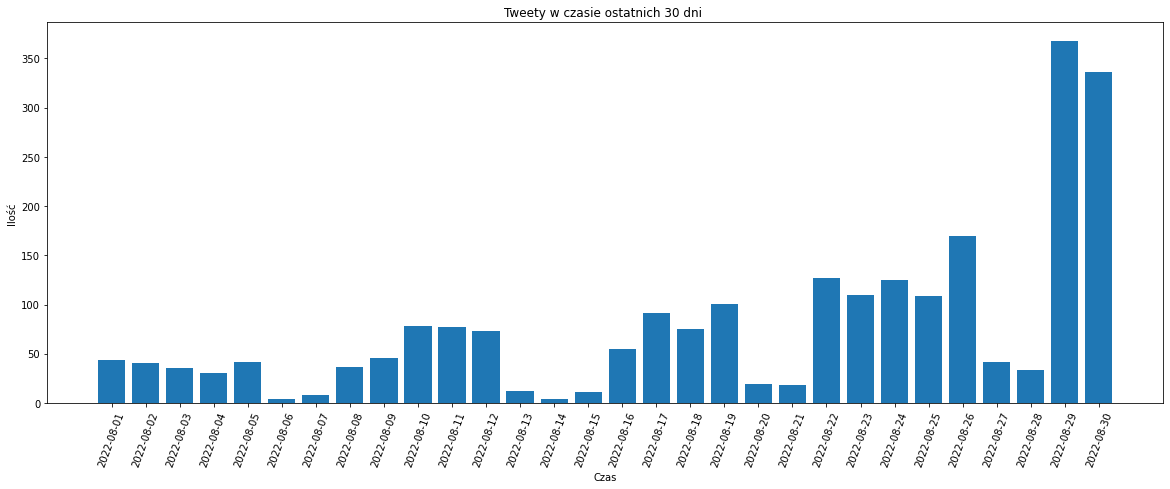

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
plt.bar(tweeter_by_date.Date[-30:], tweeter_by_date.Count[-30:])
ax.xaxis.set_tick_params(rotation=70)
ax.set_xlabel("Czas")
ax.set_ylabel('Ilość')
plt.title("Tweety w czasie ostatnich 30 dni ")
plt.show()

###Portale

In [ ]:
#tabela pokazująca ilość występowania w danych dniach
def portal_count_by_date(portal):
  uni_date = portal['Date'].unique()
  dates = portal['Date']
  uni_count = []
  for x in uni_date:
    num = 0
    for y in dates:
      if x == y:
        num += 1
    uni_count.append(num)
  by_date = {'Date':uni_date, 'Count': uni_count}
  by_date = pd.DataFrame(by_date)
  by_date = by_date.sort_values(by='Date', ignore_index=True)
  return by_date

In [ ]:
biznes_by_date = portal_count_by_date(biznesradar)
bankier_by_date = portal_count_by_date(bankier)

Biznes Radar

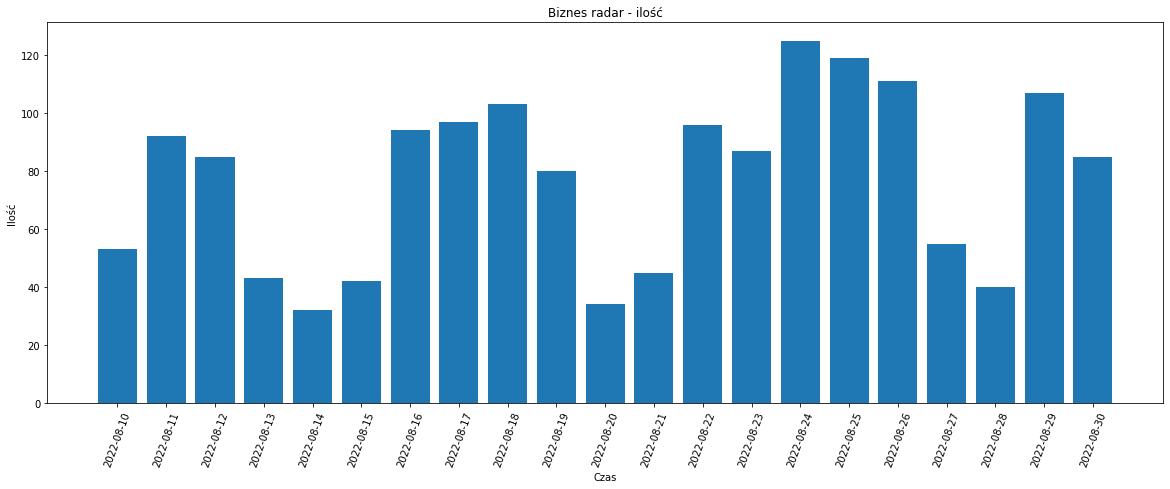

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
ax.bar(biznes_by_date.Date, biznes_by_date.Count)
ax.xaxis.set_tick_params(rotation=70)
ax.set_xlabel("Czas")
ax.set_ylabel('Ilość')
plt.title("Biznes radar - ilość")
plt.show()

bankier.pl

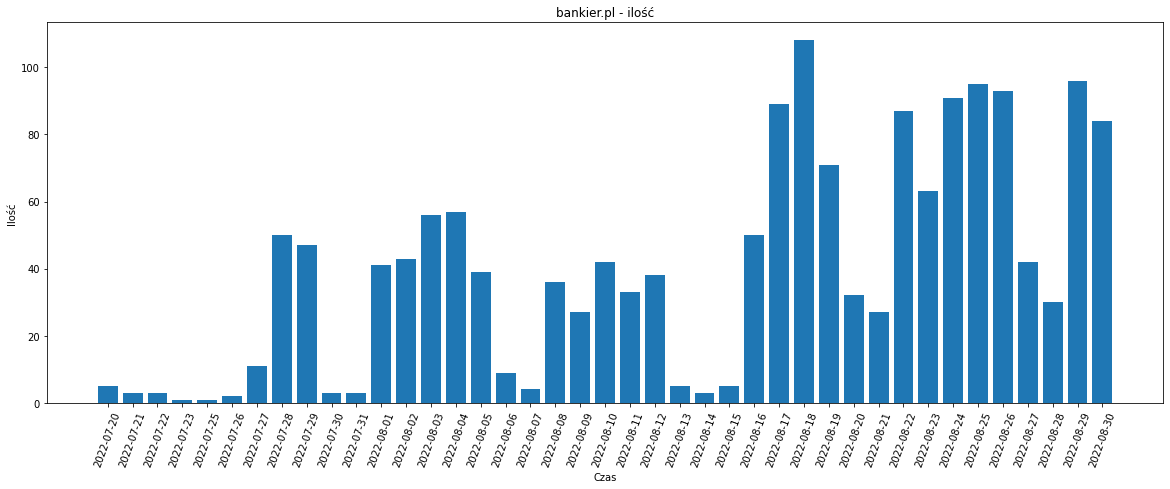

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
ax.bar(bankier_by_date.Date, bankier_by_date.Count)
ax.xaxis.set_tick_params(rotation=70)
ax.set_xlabel("Czas")
ax.set_ylabel('Ilość')
plt.title("bankier.pl - ilość")
plt.show()

#Ogarnianie textu

##Usuwanie user z tweetera

In [ ]:
twitter_no_user = twitter[['Date','Tweet']]
twitter_no_user = twitter_no_user.sort_values(by='Date', ignore_index=True, ascending=False)
twitter_no_user

,Date,Tweet
0,2022-08-30,Sprzedaż mieszkań bardzo spowolniła i nie ma p...
1,2022-08-30,UE chce tańszej energii. Co czeka europejską g...
2,2022-08-30,Polimex-Mostostal całe wakacje w wąskiej konso...
3,2022-08-30,Stabilizacja złotego. Złoty wyceniany jest prz...
4,2022-08-30,Bitcoin wykrwawia się czekając na bohatera. Sk...
...,...,...
4395,2020-08-27,Piguła informacyjna od #NEUCA Do dyspozycji ab...
4396,2020-08-25,@Cyfrowy_Ja jak w przyrodzie - nie ma dwóch id...
4397,2020-08-25,@Cyfrowy_Ja Teksty z tej serii przygotowujemy ...
4398,2020-08-25,@Cyfrowy_Ja czy możemy potraktować to ➡️ http...


##Łączenie nagłówka i początku artykułów z portali

In [ ]:
portals["combine"] = portals['Title'].astype(str) +" "+ portals["Content"]
portals_combine = portals[['Date', 'combine']]
portals_combine

,Date,combine
0,2022-08-30,Tak się pracuje w wielu firmach w Polsce. Od Z...
1,2022-08-30,Polskę i Ukrainę połączy rurociąg. Będzie tran...
2,2022-08-30,Morawiecki: przyjmujemy ewentualną konieczność...
3,2022-08-30,UE przekazuje 5 mln tabletek jodku potasu Ukra...
4,2022-08-30,"Eurocash nie wyklucza przejęć, ale stawia na o..."
...,...,...
3245,2022-08-30,Wyniki Asseco Poland w II kw. 2022 roku vs. ko...
3246,2022-08-30,MF: Czynnikami ryzyka dla prognoz makro wojna ...
3247,2022-08-30,Statbel: inflacja w Belgii w sierpniu była naj...
3248,2022-08-30,Tauron zakończył naprawę boku 910 MW w Jaworzn...


##Łączenie 2 baz ze sobą

In [ ]:
twitter_no_user.rename(columns = {'Tweet':'Text'}, inplace = True)
portals_combine.rename(columns = {'combine':'Text'}, inplace = True)
frames = [twitter_no_user, portals_combine]
all = pd.concat(frames, ignore_index=True )

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
all = all.sort_values(by='Date', ignore_index=True, ascending=False)

In [ ]:
all.sample(20)

,Date,Text
1968,2022-08-25,Rząd chce przeznaczyć miliardy zł na inwestycj...
725,2022-08-29,"Kurs dolara wsparty niezłomnością Fed, euro na..."
7616,2021-01-14,Większość rekomendacji wydanych w grudniu to t...
5270,2022-08-03,Poznaj #PortalGeostatystyczny w nowej odsłonie...
7405,2022-01-12,W ubiegłym roku na rynkach finansowych wrażeń ...
4385,2022-08-12,GUS rewiduje dane o lipcowej inflacji. Szczytu...
3328,2022-08-19,Wiceminister Ciecióra: Będą wypłacane rekompen...
628,2022-08-29,Ulga na ekspansję a reklama i sprzedaż w Inter...
7215,2022-03-24,"Podobnie jak wielkość sektorów bankowych, tak ..."
4063,2022-08-16,YouTube planuje wprowadzić nową usługę. Ma nią...


##PL Stop words - usuwanie

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python3 -m spacy download pl_core_news_sm

In [ ]:
import spacy
import pl_core_news_sm

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
pl_stop_words = ['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'ależ', 'ani', 'aż', 
                 'bardziej', 'bardzo', 'bo', 'bowiem', 'by', 'byli', 'bynajmniej', 'być', 'był', 'była', 
                 'było', 'były', 'będzie', 'będą', 'cali', 'cała', 'cały', 'ci', 'cię', 'ciebie', 'co','cokolwiek', 
                 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla', 'dlaczego', 
                 'dlatego', 'do', 'dobrze', 'dokąd', 'dość', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dziś', 'dzisiaj', 
                 'gdy', 'gdyby', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzieś', 'i', 'ich', 'ile', 'im', 'inna', 'inne', 'inny', 
                 'innych', 'iż', 'ja', 'ją', 'jak', 'jakaś', 'jakby', 'jaki', 'jakichś', 'jakie', 'jakiś', 'jakiż', 
                 'jakkolwiek', 'jako', 'jakoś', 'je', 'jeden', 'jedna', 'jedno', 'jednak', 'jednakże', 'jego', 'jej', 'jemu', 
                 'jest', 'jestem', 'jeszcze', 'jeśli', 'jeżeli', 'już', 'ją', 'każdy', 'kiedy', 'kilka', 'kimś', 'kto', 
                 'ktokolwiek', 'ktoś', 'która', 'które', 'którego', 'której', 'który', 'których', 'którym', 'którzy', 'ku', 
                 'lat', 'lecz', 'lub', 'ma', 'mają', 'mieć', 'móc', 'mało', 'mam', 'mi', 'mimo', 'między', 'mną', 'mnie', 'mogą', 'moi', 
                 'moim', 'moja', 'moje', 'może', 'możliwe', 'można', 'mój', 'mu', 'musi', 'my', 'na', 'nad', 'nam', 'nami', 
                 'nas', 'nasi', 'nasz', 'nasza', 'nasze', 'naszego', 'naszych', 'natomiast', 'natychmiast', 'nawet', 'nią', 
                 'nic', 'nich', 'nie', 'niech', 'niego', 'niej', 'niemu', 'nigdy', 'nim', 'nimi', 'niż', 'no', 'o', 'obok', 
                 'od', 'około', 'on', 'ona', 'one', 'oni', 'ono', 'oraz', 'oto', 'owszem', 'pan', 'pana', 'pani', 'po', 
                 'pod', 'podczas', 'pomimo', 'ponad', 'ponieważ', 'powinien', 'powinna', 'powinni', 'powinno', 'poza', 'prawie', 
                 'przecież', 'przed', 'przede', 'przedtem', 'przez', 'przy', 'roku', 'również', 'sama', 'są', 'się', 'skąd', 
                 'sobie', 'sobą', 'sposób', 'swoje', 'ta', 'tak', 'taka', 'taki', 'takie', 'także', 'tam', 'te', 'tego', 'tej', 
                 'temu', 'ten', 'teraz', 'też', 'to', 'tobą', 'tobie', 'toteż', 'trzeba', 'tu', 'tutaj', 'twoi', 'twoim', 'twoja', 
                 'twoje', 'twym', 'twój', 'ty', 'tych', 'tylko', 'tym', 'u', 'w', 'wam', 'wami', 'was', 'wasz', 'wasza', 'wasze', 
                 'we', 'według', 'wiele', 'wielu', 'więc', 'więcej', 'wszyscy', 'wszystkich', 'wszystkie', 'wszystkim', 'wszystko', 
                 'wtedy', 'wy', 'właśnie', 'z', 'za', 'zapewne', 'zawsze', 'ze', 'zł', 'znowu', 'znów', 'został', 'żaden', 'żadna', 
                 'żadne', 'żadnych', 'że', 'żeby', '@', '#', '$', '!', '%', '.', ',', '?', '-', ':', '"', ';', '&', ')', '(', 'https',
                 '//t.co', '/', '-', '...', '—', '_' 't', 'm', 'in', 'SWIG80', 'WIG20', 'raz', 'jeden', 'miesiąc', 'styczeń', 'luty', 'marzec', 
                 'kwiecień', 'maj', 'czerwiec', 'lipiec', 'sierpień', 'wrzesień', 'październik', 'listopad', 'grudzień', 'quot', 'WIG', 
                 'wig', 'rok', 'GPW', 'dzień', 'tydzień', '\n', '…', '`','the', 'is', 'of', 'for', 'it', 'ii', 'q', 'and', 'm', 'q' 'kw', 's'
                 's', 'poniedziałek', 'wtorek', 'środa', 'czwartek', 'piątek', 'sobota', 'niedziela', 'Polska', 'polski']

In [ ]:
all_no_stop = []
all_lower =[]
a = []
for text in all['Text']:
  a.append(word_tokenize(text))


for text in a:
  b = []
  for word in text:
    x = word.lower()
    b.append(x)
  all_lower.append(b)
  
for text in all_lower:
  c = []
  for word in text:
     if word not in pl_stop_words:
      c.append(word)
  all_no_stop.append(' '.join(c))
      


In [ ]:
all_no_stop[300]

'rząd przyjął projekt budżet 2023 zakłada 65 mld deficytu //t.co/ktwidxyvsn'

In [ ]:
len(all_no_stop)

7650

##Usuwanie linków

In [ ]:
all_no_stop_no_link = []
regex = r"//t.co/.........."
for sentence in all_no_stop:
  a = re.sub(regex, '', sentence)
  all_no_stop_no_link.append(a)


In [ ]:
all_no_stop_no_link[300]

'rząd przyjął projekt budżet 2023 zakłada 65 mld deficytu '

In [ ]:
len(all_no_stop_no_link)

7650

In [ ]:
all['Text'] = all_no_stop_no_link

In [ ]:
all.sample(20)

,Date,Text
4969,2022-08-08,ogóle pomysł porównywać inwestowanie lokaty in...
2281,2022-08-24,portugalia oszacowała koszt budowy gazociągu g...
5597,2022-07-28,większy wolumen obrót wig20 zasługa ogromnych ...
3892,2022-08-17,"eo networks planuje wypłacić 0,4 dywidendy zys..."
3160,2022-08-19,wicepremier ukrainy gospodarka kraju skurczyć ...
6102,2022-07-14,piotrko31235341 zmiany relatywne część cen sta...
2549,2022-08-23,maląg waloryzacja rent emerytur sięgnie 10 pro...
5324,2022-08-02,wiktorbarcicki druga największa
3884,2022-08-17,ropa zaliczyła najniższą cenę 6 miesięcy ruszy...
3450,2022-08-18,mbank obniżył prognozę wzrostu gospodarczego '...


##Lemmantyzacja

###Stokenizowane, zlemantyzowane i wolne od stop wordsów pojedyncze słowa

In [ ]:
nlp = spacy.load('pl_core_news_sm')

In [ ]:
words_lemma = []
for x in all['Text']:
  doc = nlp(x)
  for word in doc:
    words_lemma.append(word.lemma_)
  

In [ ]:
words_lemma_no_stop =[]
for word in words_lemma:
  if word not in pl_stop_words:
    words_lemma_no_stop.append(word)

In [ ]:
words_lemma_no_stop

['sprzedaż',
 'mieszkanie',
 'spowolnić',
 'pole',
 'podnoszeć',
 'cena',
 'związek',
 'marże',
 'spadać',
 'mówić',
 'cfo',
 'marvipolu',
 'mieszkanie',
 'stanieć',
 'polak',
 'powód',
 'wysoki',
 'cena',
 'postanowić',
 'wstrzymać',
 'decyzja',
 'zakup',
 'własny',
 'metr',
 'mówić',
 'sytuacja',
 'rynek',
 'mieszkaniowy',
 'sam',
 'deweloper',
 'kształtować',
 'sytuacja',
 'wtórny',
 'rynek',
 'nieruchomość',
 'szef',
 'mon',
 'rekordowy',
 'budżet',
 'siła',
 'zbrojny',
 'rp',
 '2023',
 'rekordowy',
 'budżet',
 'siła',
 'zbrojny',
 'rp',
 '2023',
 'oświadczyć',
 'wicepremier',
 'szef',
 'mon',
 'Mariusz',
 'błaszczak',
 'odnoszeć',
 'przyjęty',
 'rząd',
 'projekt',
 'ustawa',
 'budżetowy',
 '2023',
 'kara',
 'tsue',
 'ws',
 'sędzia',
 'przekroczyć',
 '300',
 'milion',
 'euro',
 'kupić',
 'kara',
 'niezastosowanie',
 'postanowienie',
 'trybunał',
 'sprawiedliwość',
 'unia',
 'europejski',
 'sprawa',
 'system',
 'dyscyplinarny',
 'sędzia',
 'przekroczyć',
 '300',
 'milion',
 'euro',


###Data Frame zlemantyzowana i bez stop wordsów

In [ ]:
all_no_stop_lemma = []

for text in all['Text']:
  doc = nlp(text)
  a = []
  for word in doc:
    a.append(word.lemma_)
      
  all_no_stop_lemma.append(' '.join(a))

In [ ]:
all['Text'] = all_no_stop_lemma

In [ ]:
all.sample(15)

,Date,Text
1744,2022-08-25,przynieść lekki odreagować gpwa przynieść lekk...
2420,2022-08-23,premier gra gasa station simulator wersja kons...
4235,2022-08-13,ważyć los drewno pomorski las brat szef orlen ...
1008,2022-08-29,student uczelnia cywilny zainteresowany służba...
6724,2022-06-23,norgesbanek 🇳 🇴 agresywny podwyżka stopa świat...
5693,2022-07-27,mprzasnysek pewnie nieco droższe
1555,2022-08-26,świętujeć 60lecie powstać urząd statystyczny 🥳...
562,2022-08-29,nadchodzić recesyjny jesień gospodarka indeks ...
4476,2022-08-11,powstać panattoni park żara panattonić park ża...
3747,2022-08-17,golabartek zaskoczenie skala zapasy wątpić ` `...


##Podział datami

In [ ]:
all_by_date = all.groupby('Date')['Text'].agg(lambda col: ''.join(col))

In [ ]:
pd.DataFrame(all_by_date)

,Text
Date,
2020-08-25,"cyfrowy_ja tekst seria przygotowujeć 1,5 nazbi..."
2020-08-27,piguć informacyjny neucać dyspozycja abonent b...
2020-08-28,nieoczekiwany skutek pandemia ` ` samo trudno ...
2020-09-15,“ think that ever time you see word ebitda you...
2020-09-17,Bogusław sieczkowski selvito akwizycjach „ dłu...
...,...
2022-08-26,producent żywność napój apelować premier inter...
2022-08-27,duży świat sprzedawca internetowy zobowiązać o...
2022-08-28,europejski organizacja sędziowski zaskarżyć za...


##Podział na sentencje

In [ ]:
all_token_sentence = []
for text in all['Text']:
  all_token_sentence.append(sent_tokenize(text))

In [ ]:
all_token_sentence

[['sprzedaż mieszkanie spowolnić pole podnoszeć cena związek marże spadać mówić cfo marvipolu'],
 ['mieszkanie stanieć polak powód wysoki cena postanowić wstrzymać decyzja zakup własny metr .',
  'mówić sytuacja rynek mieszkaniowy sam deweloper kształtować sytuacja wtórny rynek nieruchomość'],
 ['szef mon rekordowy budżet siła zbrojny rp 2023 rekordowy budżet siła zbrojny rp 2023 oświadczyć wicepremier szef mon Mariusz błaszczak odnoszeć przyjęty rząd projekt ustawa budżetowy 2023'],
 ['kara tsue ws sędzia przekroczyć 300 milion euro kupić kara niezastosowanie postanowienie trybunał sprawiedliwość unia europejski sprawa system dyscyplinarny sędzia przekroczyć 300 milion euro 1,419 miliard złoty dokładnie tyle łącznie wynosić roczny budżeta kancelaria premier sejm'],
 ['elon Musk dostać broń ręka strzeć twitter były szef bezpieczeństwo platforma szef bezpieczeństwo twitterać nieoczekiwanie wsparł elona muski starcie platforma przekazać dowód portal stawiać wzrost liczba użytkownik zamia

In [ ]:
len(all_token_sentence)

7650

#Eksploracja

###Mapa słów

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
df_words_lemma = pd.DataFrame(words_lemma_no_stop, columns=['Text'])

In [ ]:
text = " ".join(x for x in words_lemma)
print ("Jest {} słów we wszystkich tekstach.".format(len(text)))

Jest 1320388 słów we wszystkich tekstach.


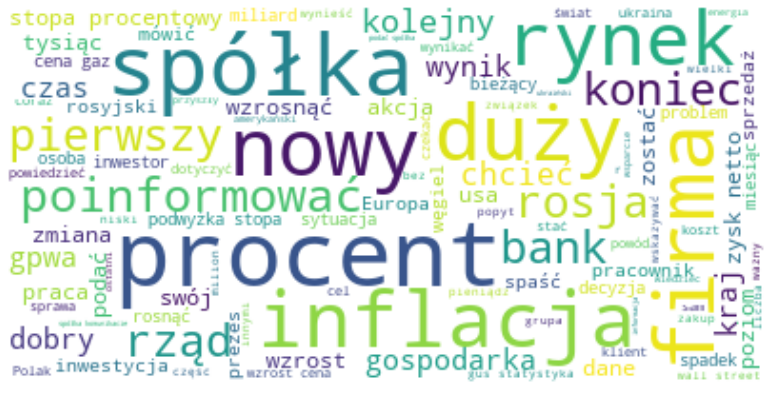

In [ ]:
wordcloud = WordCloud(stopwords=pl_stop_words, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Występowanie spółek WIG20

In [ ]:
from collections import Counter

In [ ]:
wig_20 = {'Allegro' : ['allegro', 'ale'],  #
        'Asseco' : ['asseco', 'acp'], #
        'CD Project': ['cd projekt', 'cdr'],
        'CCC': ['ccc'], #
        'Cyfrowy Polsat': ['polsat', 'cps'], #
        'Dino Polska' : ['dino', 'dnp'],#
        'PGN SA' : ['polskie górnictwo naftowe i gazownictwo', 'pgn', 'pgnig'], 
        'Grupa Kety' : ['kty', 'kęty'], #
        'JSW' : ['jastrzębska spółka węglowa', 'jsw'],#
        'KGHM Polska Miedź' : ['kghm', 'kgh'], #
        'LPP' : ['lpp'], #
        'mBank' : ['mbank', 'mbk'] , #
        'Orange Polska' : ['orange', 'opl'], 
        'Pekao BP' : ['polska kasa opieki', 'pekao', 'peo'],#
        'Pepco' : ['pepco', 'pco'], #
        'PGE' : ['pge polska grupa energetyczna', 'pge'],#
        'Orlen' : ['polski koncern naftowy', 'orlen', 'pkn'],#
        'PKO BP' : ['powszechna kasa oszczednosci bank polski', 'pko'], #
        'PZU' : ['powszechny zakład ubezpieczeń', 'pzu'], #
        'Santander' : ['santander', 'spl']}#

In [ ]:
wig_20_freq = []
for k, i in wig_20.items():
  for word in words_lemma_no_stop:
    if word in i:
      wig_20_freq.append(k)

wig_20_count = Counter(wig_20_freq)
wig_20_count = {k: v for k, v in sorted(wig_20_count.items(), key=lambda item: item[1], reverse=True)}

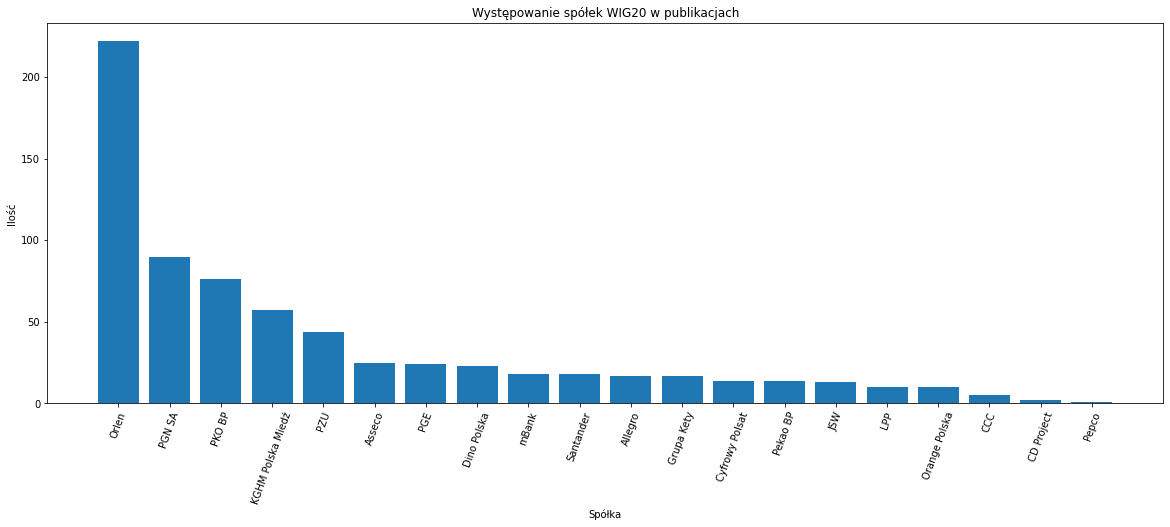

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
ax.xaxis.set_tick_params(rotation=70)
ax.set_xlabel("Spółka")
ax.set_ylabel('Ilość')
plt.title("Występowanie spółek WIG20 w publikacjach")
plt.bar(range(len(wig_20_count)), list(wig_20_count.values()), align='center')
plt.xticks(range(len(wig_20_count)), list(wig_20_count.keys()))
plt.show()

##Sentyment

### Przypisanie sentymentu ze zbioru LOBI

In [ ]:
#LOBI do słownika
nawl_dict = pd.read_csv('/content/nawl-analysis.csv', header=None, index_col=0, squeeze=True).to_dict()
#wyciągnięcie tylko kategorii
nawl_cat = nawl_dict[1]
len(nawl_cat)

2903

In [ ]:
# Policzenie wystąpień słów z listy słów zlemmatyzowanych i przypisanie Kategorii
sent_category = []
for k, i in nawl_cat.items():
  for word in words_lemma_no_stop:
    if word in k:
      sent_category.append(i)

sent_category = Counter(sent_category)

In [ ]:
#zmiana na df i zdropowanie kategorii, neutral, unclassified i zamiana na polskie nazwy
df_sent_category = pd.DataFrame.from_dict(sent_category, orient='index', dtype=None, columns=['Ilość'])
df_sent_category = df_sent_category.drop(['category', 'N', 'U'])
df_sent_category.rename(index={'H': 'Szczęście',
                               'A': 'Złość', 
                               'S': 'Smutek',
                               'F': 'Strach',
                               'D': 'Wstręt'}, inplace=True)
#sortowanie po ilości wystąpień
df_sent_category = df_sent_category.sort_values(by=['Ilość'],ascending=False)                          

In [ ]:
df_sent_category

,Ilość
Strach,25606
Szczęście,20224
Złość,16513
Smutek,8713
Wstręt,5666


###Wykres sentymentu

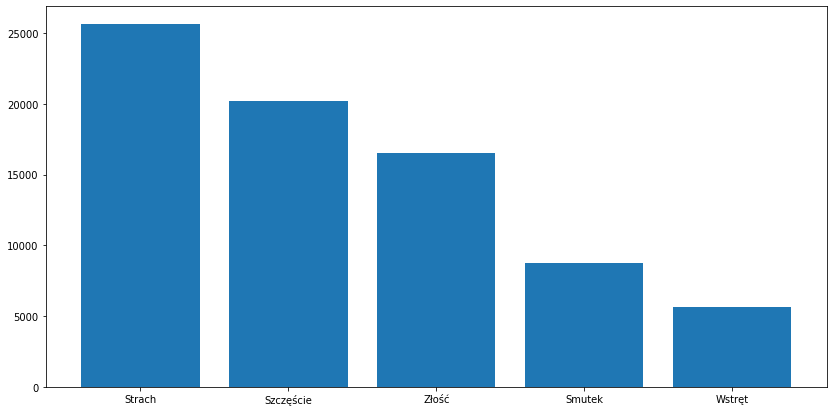

In [ ]:
height = df_sent_category.Ilość
bars = df_sent_category.index
x_pos = np.arange(len(df_sent_category))

fig, ax = plt.subplots(figsize=(14,7))
plt.bar(x_pos, height)


plt.xticks(x_pos, bars)

# Show graph
plt.show()

##Wykresy giełdowe

###Ceny akcji

Text(0.5, 0.98, 'Ceny Akcji WIG 20')

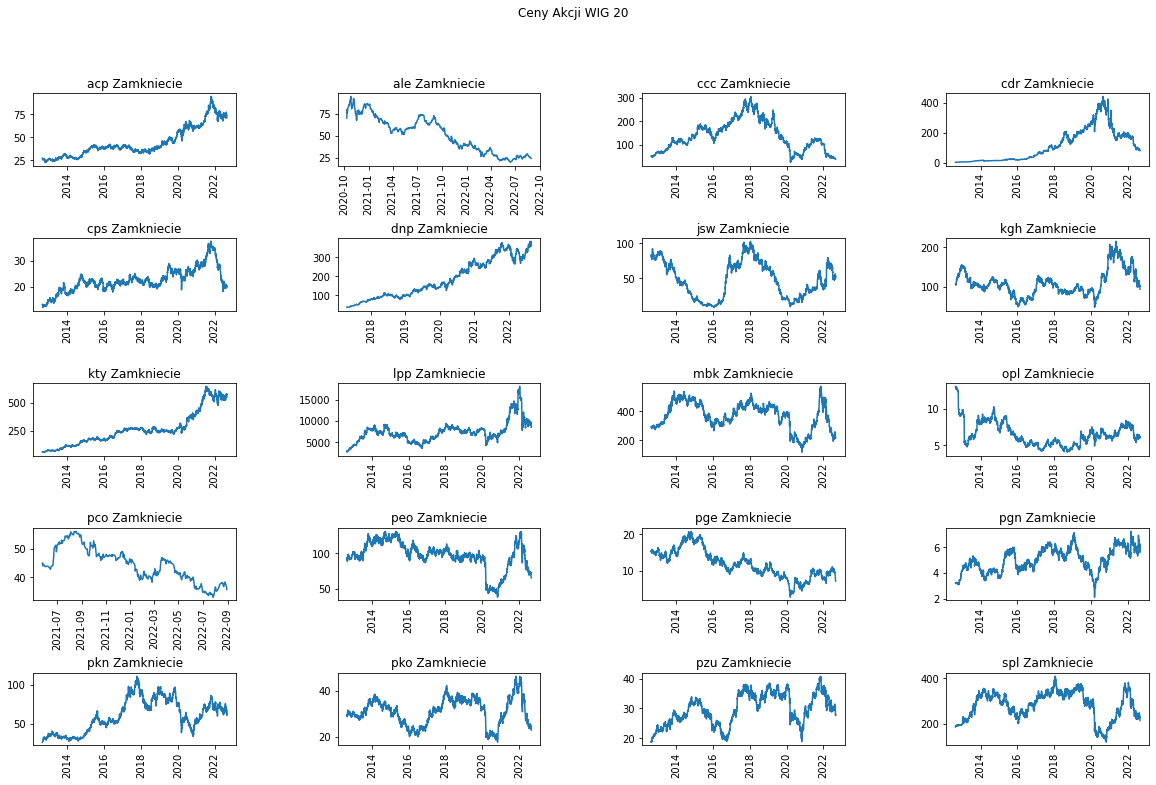

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(len(tiki_zamkniecie)):
    plt.subplot(5,4,i+1)
    plt.subplots_adjust( hspace=1 ,wspace=0.5)
    plt.title(tiki_zamkniecie[i])
    plt.plot(stocks[tiki_zamkniecie[i]])
    plt.xticks(rotation=90)
plt.suptitle("Ceny Akcji WIG 20")

###Zmiany procentowe

Text(0.5, 0.98, 'Zmiany procentowe spółek WIG20')

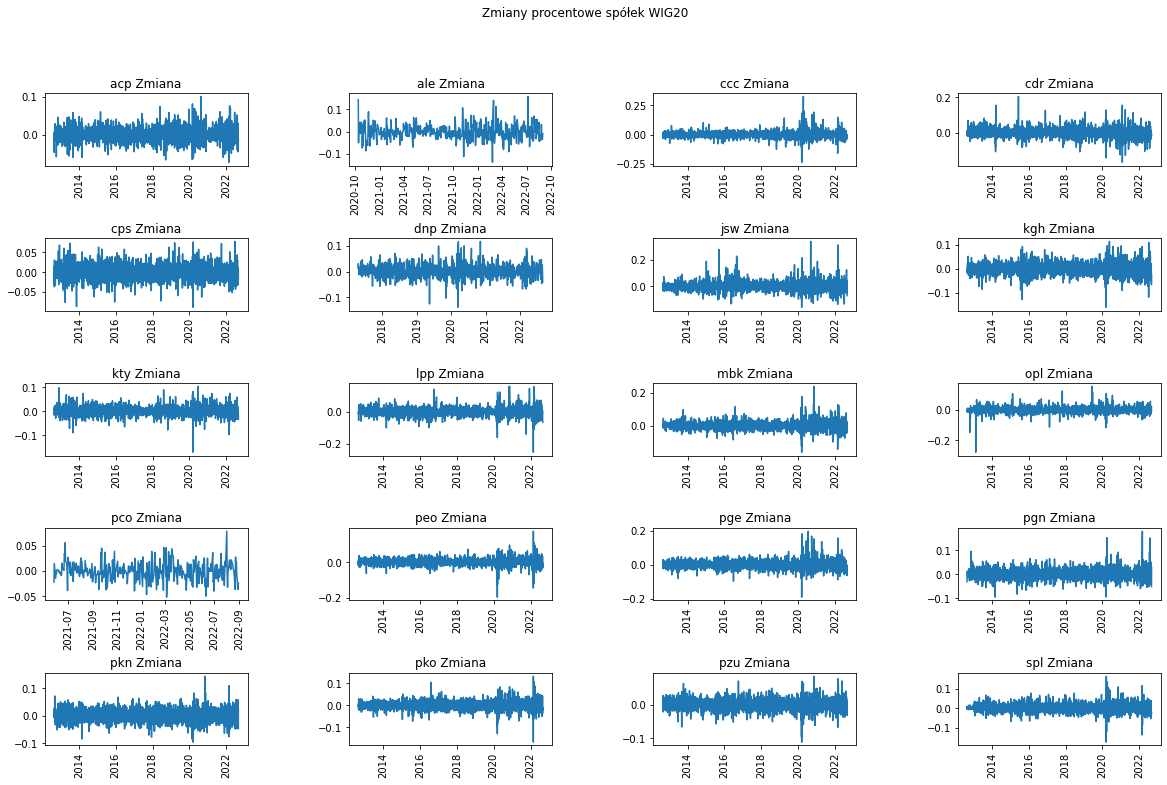

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(len(tiki_zmiana)):
    plt.subplot(5,4,i+1)
    plt.subplots_adjust( hspace=1 ,wspace=0.5)
    plt.title(tiki_zmiana[i])
    plt.plot(stocks[tiki_zmiana[i]])
    plt.xticks(rotation=90)
plt.suptitle("Zmiany procentowe spółek WIG20")

###Porównianie "dużego" WIG z WIG20

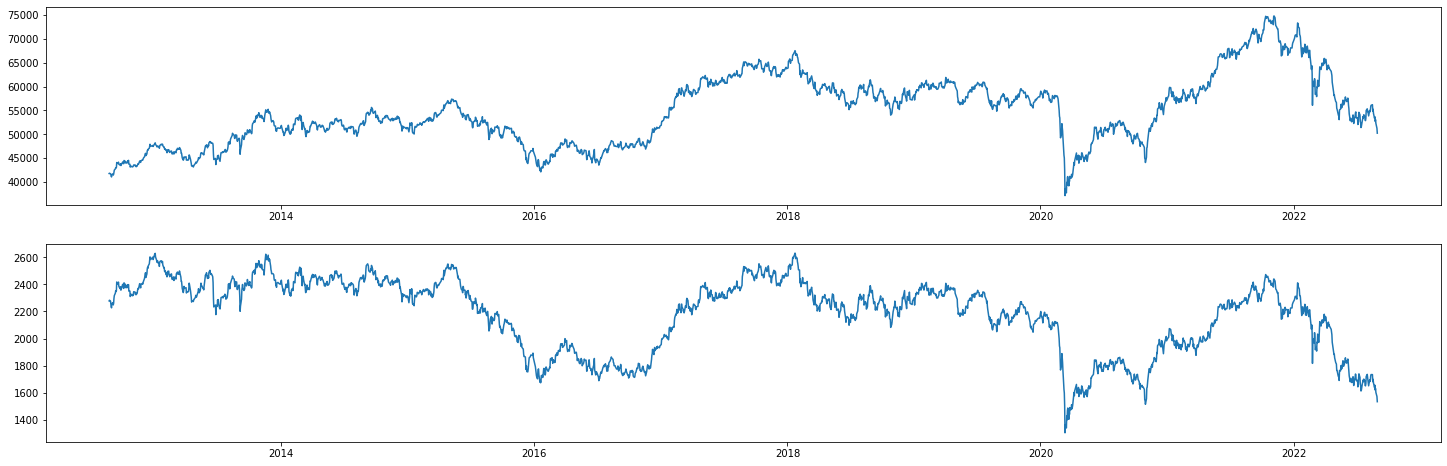

In [ ]:
fig, ax = plt.subplots(2,figsize=(25,8))
ax[0].plot(wig['wig Zamkniecie'])
ax[1].plot(wig20['wig20 Zamkniecie'])

###Korelacja cen zamknięcia spółek WIG 20

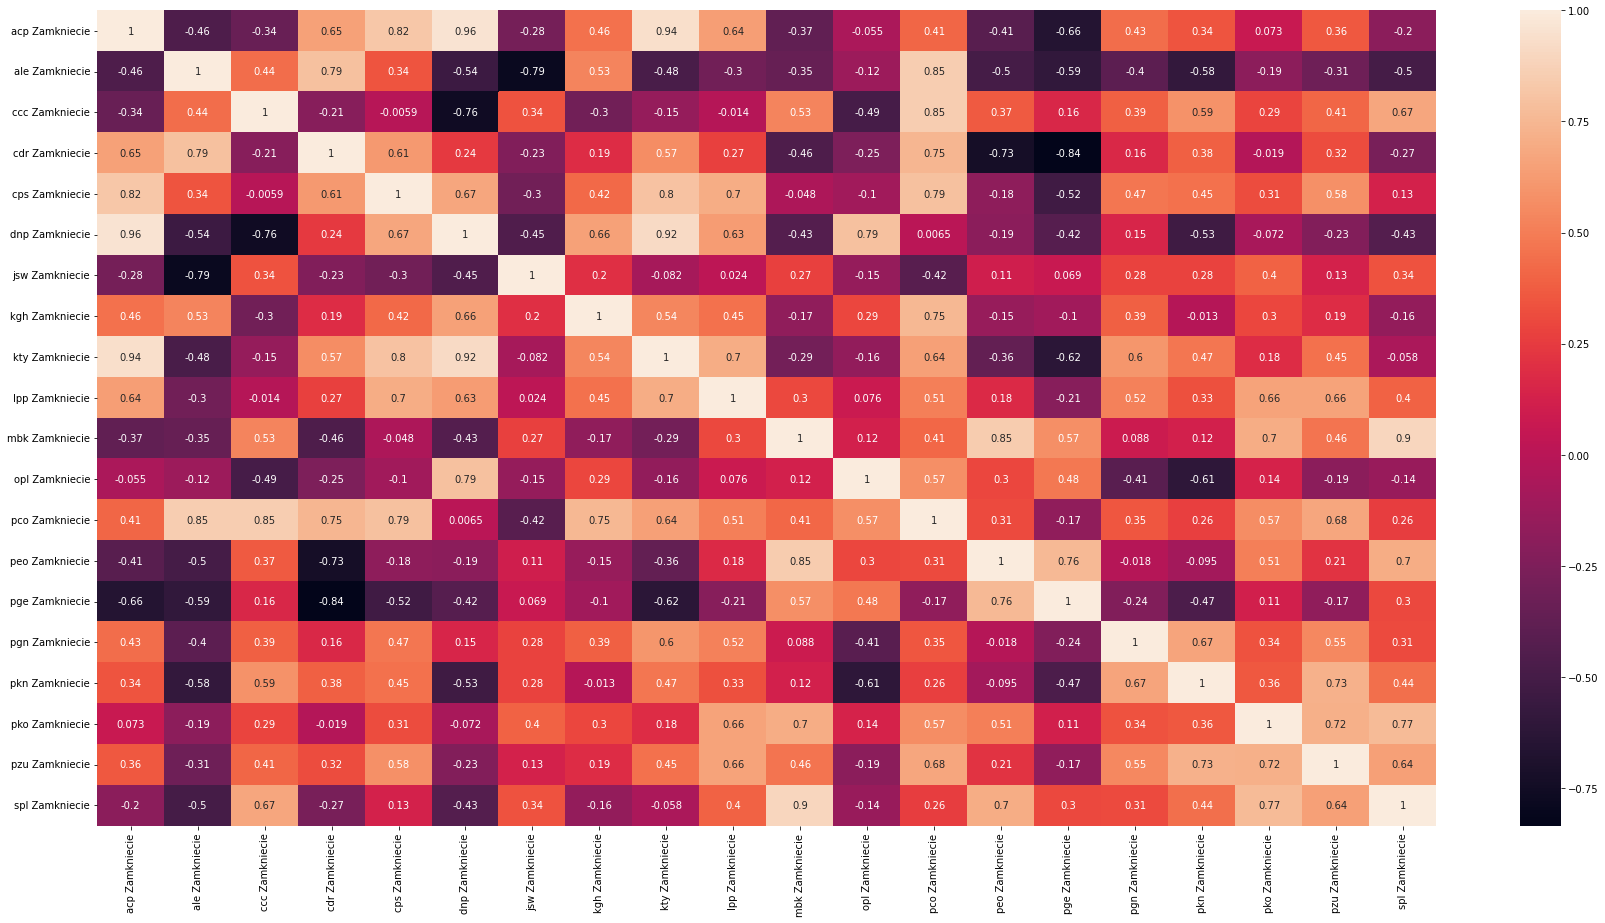

In [ ]:
correlation = stocks[tiki_zamkniecie].corr()
fig = plt.figure(figsize = (30, 15))
sns.heatmap(correlation, annot = True)
plt.show()

###Korelacja dziennych zmian spółek WIG 20

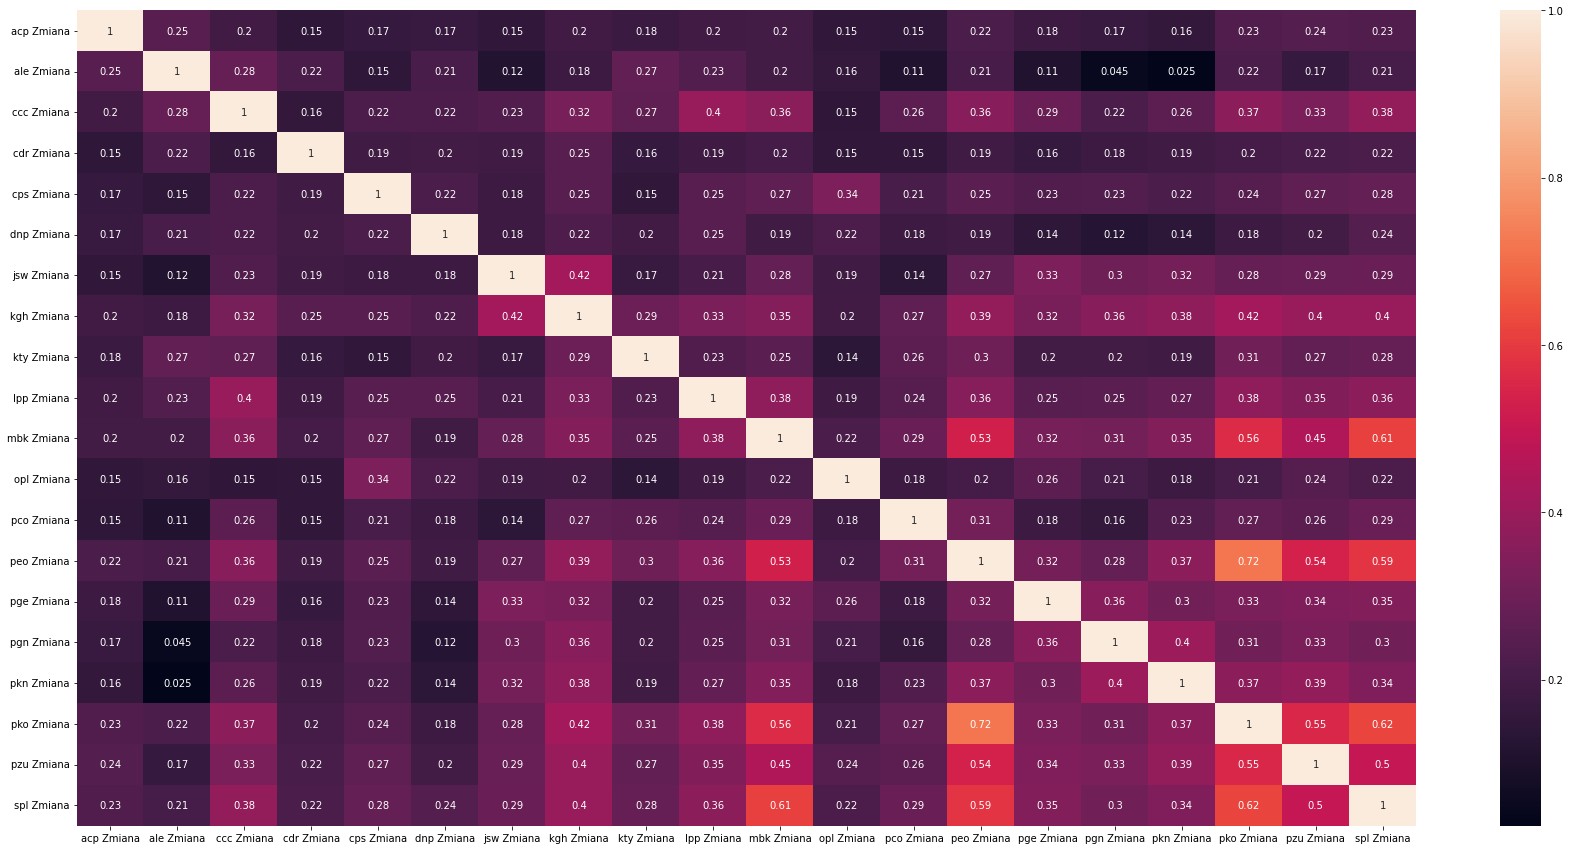

In [ ]:
plt.figure(figsize=(30,15))
correlation = stocks[tiki_zmiana].corr()
sns.heatmap(correlation, annot=True)
plt.show()

###Korelacja dziennych wolumenów spółek WIG 20

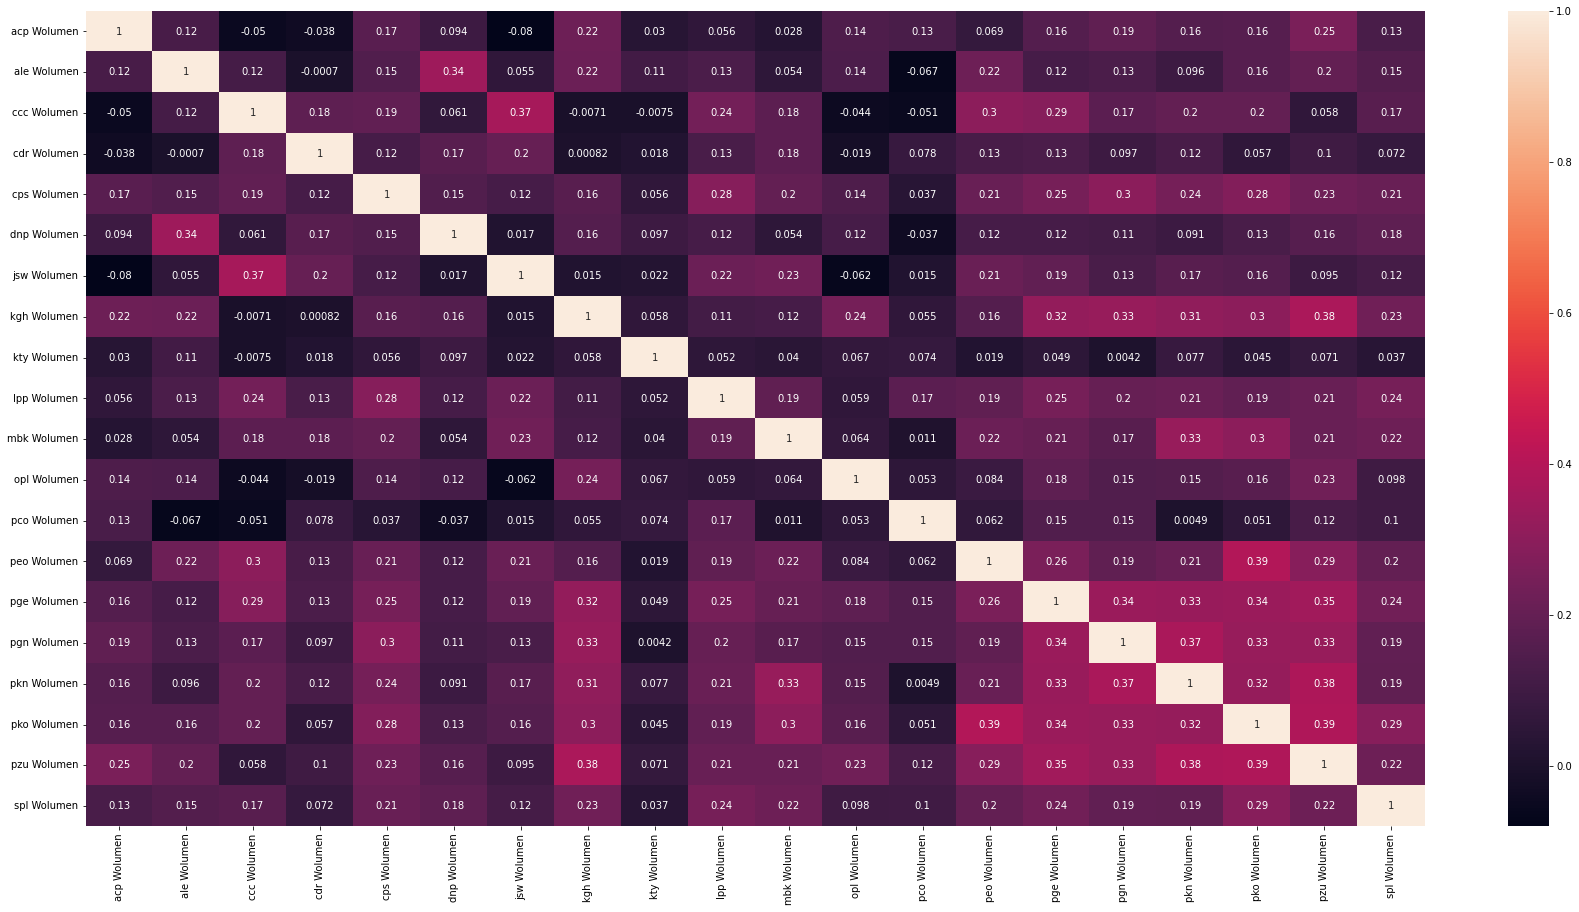

In [ ]:
plt.figure(figsize=(30,15))
correlation = stocks[tiki_wolumen].corr()
sns.heatmap(correlation, annot=True)
plt.show()

###Box plot z cenami

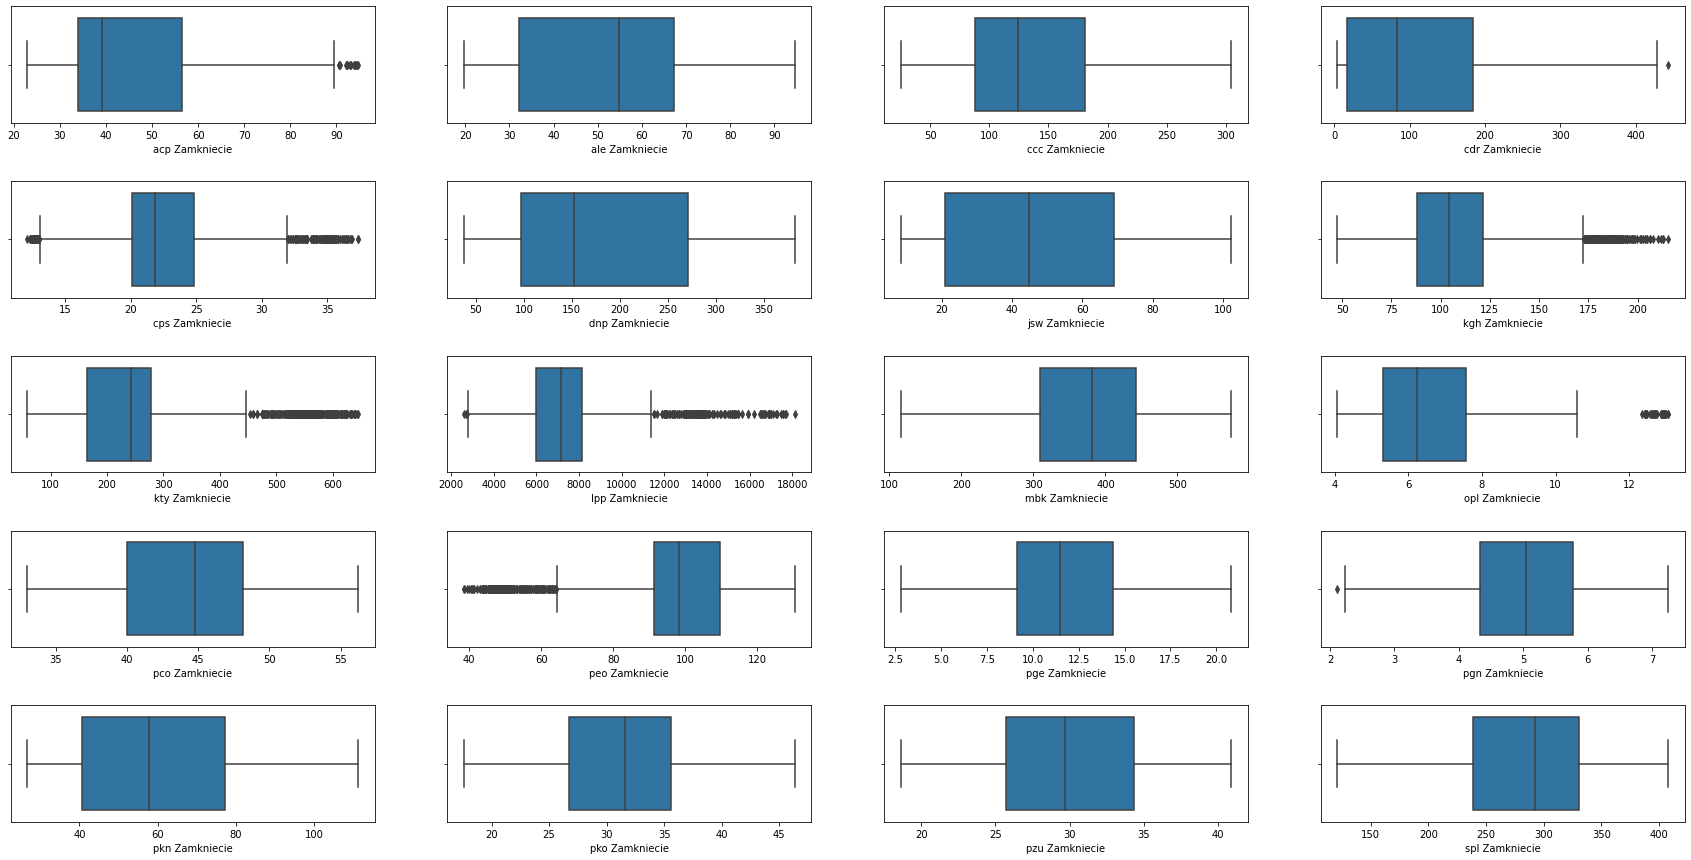

In [ ]:
plt.figure(figsize=(30, 15))

for i in range(len(tiki_zamkniecie)):
    plt.subplot(5, 4, i+1)
    plt.subplots_adjust( hspace=0.5 )
    sns.boxplot(x=stocks[tiki_zamkniecie[i]])

###Box Plot z zmianami procentowymi

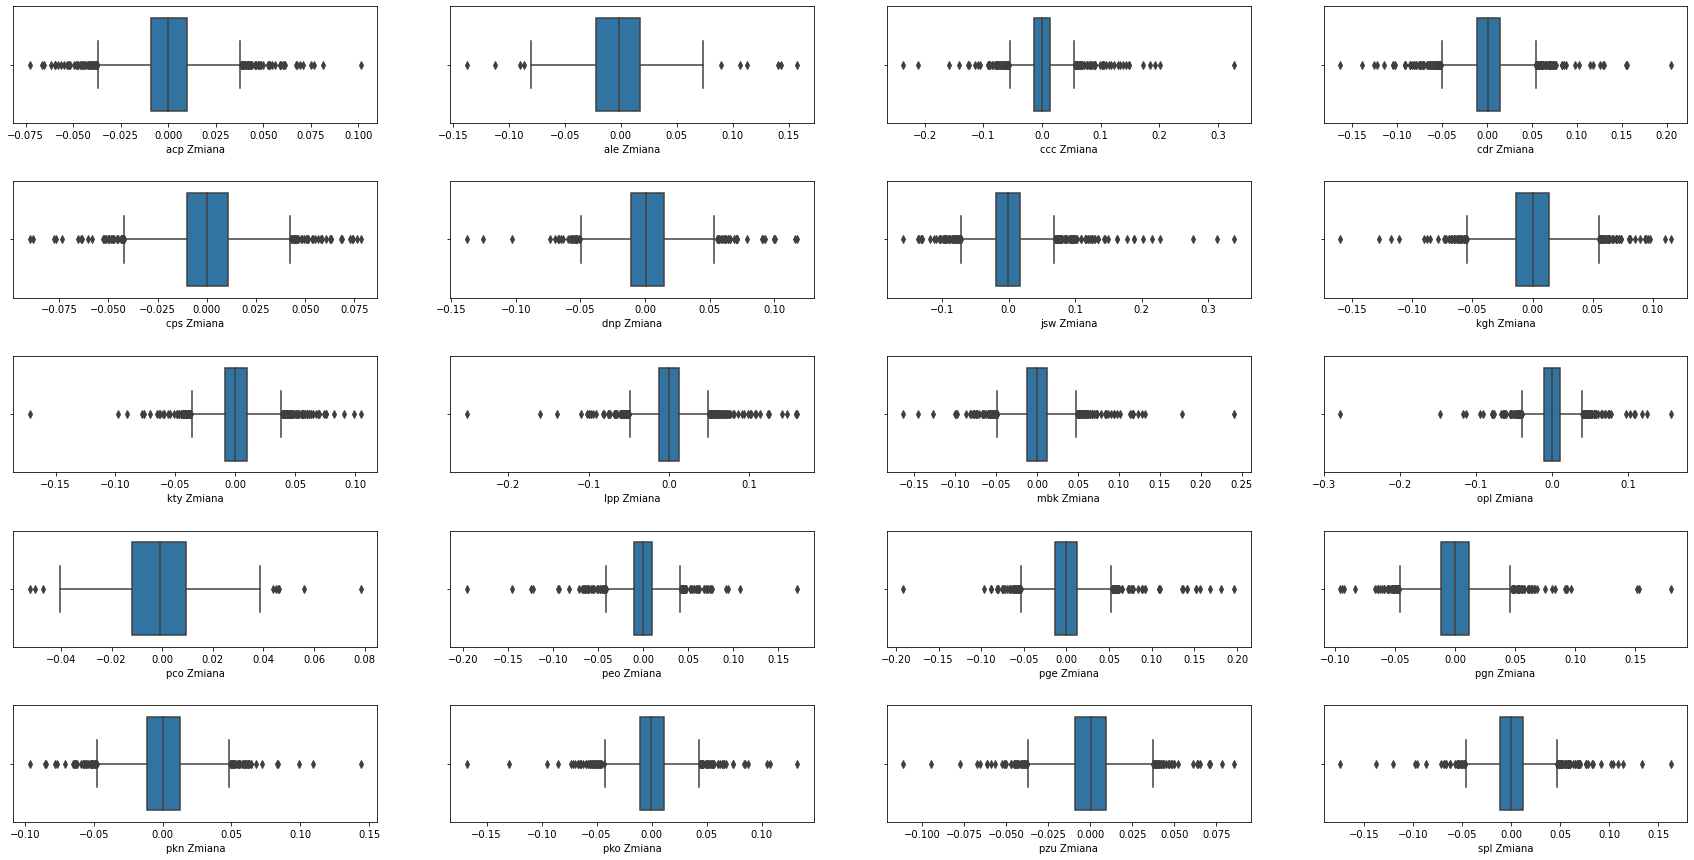

In [ ]:
plt.figure(figsize=(30, 15))

for i in range(len(tiki_zmiana)):
    plt.subplot(5, 4, i+1)
    plt.subplots_adjust( hspace=0.5 )
    sns.boxplot(x=stocks[tiki_zmiana[i]])

#Topic modeling

LDA nienadzorowane uczenie maszynowe, które stosuje techniki grupowania do znajdowania ukrytych struktur.

In [ ]:
from gensim import corpora
from gensim.utils import tokenize


descriptions = [list(tokenize(t)) for t in all['Text']]

dictionary = corpora.Dictionary(descriptions)
corpus = [dictionary.doc2bow(text) for text in descriptions]

In [ ]:
import gensim
NUM_TOPICS = 4
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=50)

In [ ]:
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
  print(topic)

(0, '0.009*"ropa" + 0.007*"produkcja" + 0.007*"cena" + 0.005*"q"')
(1, '0.007*"spółka" + 0.005*"dolar" + 0.005*"kurs" + 0.005*"euro"')
(2, '0.010*"rynek" + 0.009*"gpwa" + 0.008*"stopa" + 0.007*"inflacja"')
(3, '0.022*"rok" + 0.015*"procent" + 0.011*"milion" + 0.011*"cena"')


In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=True)
pyLDAvis.save_html(lda_display, 'sk_topics.html')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


#Klasteryzacja Hierarchiczna

##Dywersyfikacja spółek ze względu na dzienne zmiany cenowe

In [ ]:
price_change = get_price_change()

Pobieram dzienne zmiany procentowe: acp
Pobieram dzienne zmiany procentowe: ale
Pobieram dzienne zmiany procentowe: ccc
Pobieram dzienne zmiany procentowe: cdr
Pobieram dzienne zmiany procentowe: cps
Pobieram dzienne zmiany procentowe: dnp
Pobieram dzienne zmiany procentowe: jsw
Pobieram dzienne zmiany procentowe: kgh
Pobieram dzienne zmiany procentowe: kty
Pobieram dzienne zmiany procentowe: lpp
Pobieram dzienne zmiany procentowe: mbk
Pobieram dzienne zmiany procentowe: opl
Pobieram dzienne zmiany procentowe: pco
Pobieram dzienne zmiany procentowe: peo
Pobieram dzienne zmiany procentowe: pge
Pobieram dzienne zmiany procentowe: pgn
Pobieram dzienne zmiany procentowe: pkn
Pobieram dzienne zmiany procentowe: pko
Pobieram dzienne zmiany procentowe: pzu
Pobieram dzienne zmiany procentowe: spl


In [ ]:
price_change_corr_matrix = price_change.corr()

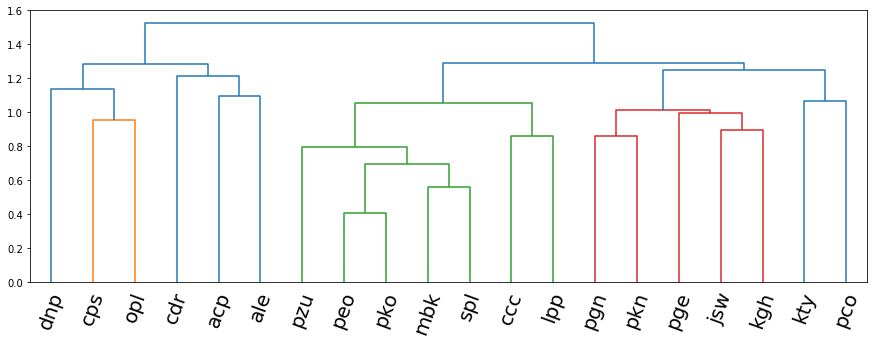

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram


mergings = linkage(price_change_corr_matrix, method='complete')

fig, ax = plt.subplots(figsize=(15,5))
dendrogram(mergings,
           labels=price_change_corr_matrix.index,
           leaf_rotation=70,
           leaf_font_size=20,
            )
plt.show()

##Dywersyfikacja spółek ze względu na dzienne wolumeny ilościowe

In [ ]:
wolumen = get_all_volumen()
wolumen_corr_matrix = wolumen.corr()

Pobieram dzienne wolumeny obrotu: acp
Pobieram dzienne wolumeny obrotu: ale
Pobieram dzienne wolumeny obrotu: ccc
Pobieram dzienne wolumeny obrotu: cdr
Pobieram dzienne wolumeny obrotu: cps
Pobieram dzienne wolumeny obrotu: dnp
Pobieram dzienne wolumeny obrotu: jsw
Pobieram dzienne wolumeny obrotu: kgh
Pobieram dzienne wolumeny obrotu: kty
Pobieram dzienne wolumeny obrotu: lpp
Pobieram dzienne wolumeny obrotu: mbk
Pobieram dzienne wolumeny obrotu: opl
Pobieram dzienne wolumeny obrotu: pco
Pobieram dzienne wolumeny obrotu: peo
Pobieram dzienne wolumeny obrotu: pge
Pobieram dzienne wolumeny obrotu: pgn
Pobieram dzienne wolumeny obrotu: pkn
Pobieram dzienne wolumeny obrotu: pko
Pobieram dzienne wolumeny obrotu: pzu
Pobieram dzienne wolumeny obrotu: spl


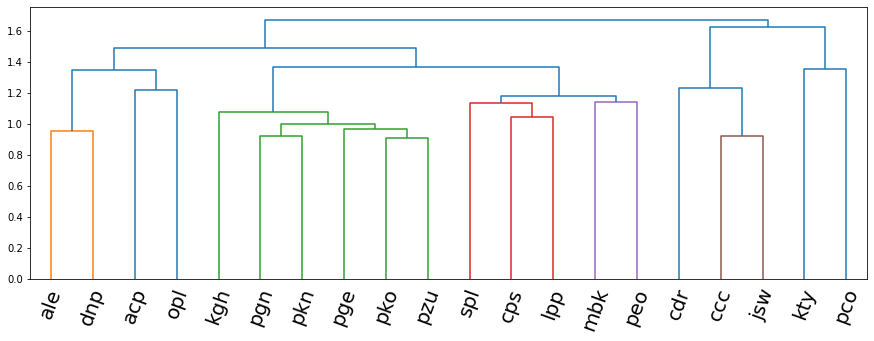

In [ ]:
mergings = linkage(wolumen_corr_matrix, method='complete')

fig, ax = plt.subplots(figsize=(15,5))
dendrogram(mergings,
           labels=wolumen_corr_matrix.index,
           leaf_rotation=70,
           leaf_font_size=20,
            )
plt.show()